## Semantic mashup

Below is a link to the data we linked to wikidata.
> https://www.kaggle.com/datasets/swaptr/fifa-world-cup-2022-player-data?resource=download&select=player_stats.csv

In [ ]:
!pip install sparqlwrapper pandas rdflib tqdm IPython matplotlib

In [2]:
import SPARQLWrapper as wr
import pandas as pd
import time
import rdflib
from tqdm.notebook import tqdm
import IPython
from matplotlib import pyplot as plt

In [3]:
player_df = pd.read_csv('player_stats.csv')
player_df.head()

,player,position,team,age,club,birth_year,games,games_starts,minutes,minutes_90s,...,goals_assists_pens_per90,xg,npxg,xg_assist,npxg_xg_assist,xg_per90,xg_assist_per90,xg_xg_assist_per90,npxg_per90,npxg_xg_assist_per90
0,Aaron Mooy,MF,Australia,32-094,Celtic,1990,4,4,360,4.0,...,0.0,0.0,0.0,0.1,0.1,0.01,0.02,0.03,0.01,0.03
1,Aaron Ramsey,MF,Wales,31-357,Nice,1990,3,3,266,3.0,...,0.0,0.0,0.0,0.0,0.1,0.01,0.01,0.02,0.01,0.02
2,Abdelhamid Sabiri,MF,Morocco,26-020,Sampdoria,1996,5,2,181,2.0,...,0.5,0.1,0.1,0.9,1.0,0.08,0.53,0.60,0.08,0.60
3,Abdelkarim Hassan,DF,Qatar,29-112,Al Sadd SC,1993,3,3,270,3.0,...,0.0,0.3,0.3,0.0,0.3,0.10,0.01,0.11,0.10,0.11
4,Abderrazak Hamdallah,FW,Morocco,32-001,Al-Ittihad,1990,4,0,68,0.8,...,0.0,0.4,0.4,0.0,0.4,0.52,0.00,0.52,0.52,0.52


In [4]:
graph = rdflib.Graph()
FIFA = rdflib.Namespace("http://www.fifastat.org/")
graph.bind('fifa', FIFA) 

### Data preparation

In [5]:
player_df.drop(columns=['birth_year', 'minutes_90s', 'goals_pens', 'goals_per90', 'assists_per90', 
                        'goals_assists_per90', 'goals_pens_per90', 'goals_assists_pens_per90', 
                        'xg', 'npxg', 'xg_assist', 'npxg_xg_assist', 'xg_per90', 'xg_assist_per90',       
                        'xg_xg_assist_per90', 'npxg_per90', 'npxg_xg_assist_per90'], inplace=True)

In [6]:
player_df['team'] = player_df['team'].replace(
    ['IR Iran', 'Korea Republic', 'United States'], 
    ['Iran', 'South Korea', 'United States of America']
)

In [7]:
player_df.insert(0, "uri", "") 
player_df.insert(2, "pic", "https://cdn-icons-png.flaticon.com/512/72/72941.png")

In [8]:
wikidata = wr.SPARQLWrapper("https://query.wikidata.org/sparql")
wikidata.setReturnFormat(wr.JSON)

### Getting countries and flags

In [9]:
def getCountry(countryLabel):
    
    wikidata.setQuery(f"""
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>

    SELECT DISTINCT ?country ?flag
    WHERE {{
        ?country rdfs:label "{countryLabel}"@en ;
                 wdt:P41 ?flag .
        FILTER EXISTS {{?country wdt:P163 ?o }}
    }}
    ORDER BY DESC(?flag)
    LIMIT 1
    """)    
    
    try:
        results = wikidata.query().convert()
    except:
        time.sleep(10)
        return getCountry(countryLabel)
    
    result = results["results"]["bindings"]
    
    if len(result) >= 1:
        uri = result[0]["country"]["value"]
        try:
            img = result[0]["flag"]["value"]
        except:
            img = ""
        return uri, img
    return countryLabel, ""

In [10]:
countries = player_df.team.unique()

img_flag = []

bar_c = tqdm(total=len(countries), desc="Downloading... ")

for country in countries:
    uri, flag = getCountry(country)
    
    graph.add((
        rdflib.URIRef(uri),
        rdflib.RDFS.label,                   
        rdflib.Literal(country)                  
    ))
    
    graph.add((
        rdflib.URIRef(uri),
        FIFA.flag,                   
        rdflib.URIRef(flag)                  
    ))
    
    player_df['team'] = player_df['team'].replace(country, uri)
    
    bar_c.update(1)

Downloading... :   0%|          | 0/32 [00:00<?, ?it/s]

### Getting players URI and images (it may take some time)

In [11]:
def getPlayer(playerLabel, country):
    
    wikidata.setQuery(f"""
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>

    SELECT DISTINCT ?player ?img
    WHERE {{
        ?player wdt:P1532 <{country}> ;
                wdt:P106 wd:Q937857 ;
                wdt:P21  wd:Q6581097 ;
                rdfs:label ?player_name .
                
        FILTER(str(?player_name)="{playerLabel}")
        OPTIONAL{{?player wdt:P18 ?img .}}
    }}
    """)

    try:
        results = wikidata.query().convert()
    except:
        time.sleep(10)
        return getPlayer(playerLabel, country)
    
    result = results["results"]["bindings"]
        
    if len(result) >= 1:
        uri = result[0]["player"]["value"]
        try:
            img = result[0]["img"]["value"]
        except:
            img = ""
        return uri, img
    return "not found", ""

In [12]:
bar_p = tqdm(total=len(player_df), desc="Downloading... ")

for index, row in player_df.iterrows():
    uri, img = getPlayer(row["player"], row["team"])
    player_df.loc[player_df.player == row["player"], 'uri'] = uri
    
    if img != "":
        player_df.loc[player_df.player == row["player"], 'pic'] = img

    bar_p.update(1)

Downloading... :   0%|          | 0/680 [00:00<?, ?it/s]

In [13]:
player_df = player_df[player_df.uri != 'not found']

### Converting to triplestore

In [14]:
for _, row in player_df.iterrows():
    uri = rdflib.URIRef(row['uri'])
    
    graph.add((
        uri,
        rdflib.RDFS.label,                  
        rdflib.Literal(row['player'])                  
    ))
    graph.add((
        uri,
        FIFA.pic,                  
        rdflib.URIRef(row['pic'])                  
    ))
    graph.add((
        uri,
        FIFA.position,                  
        rdflib.Literal(row['position'])                  
    ))
    graph.add((
        uri,
        FIFA.team,                  
        rdflib.URIRef(row['team'])                  
    ))
    graph.add((
        uri,
        FIFA.age,                  
        rdflib.Literal(row['age'].split('-')[0])                  
    ))
    graph.add((
        uri,
        FIFA.club,                  
        rdflib.Literal(row['club'])                  
    ))
    graph.add((
        uri,
        FIFA.games,                  
        rdflib.Literal(row['games'])                  
    ))
    graph.add((
        uri,
        FIFA.minutes,                  
        rdflib.Literal(row['minutes'])                  
    ))
    graph.add((
        uri,
        FIFA.goals,                  
        rdflib.Literal(row['goals'])                  
    ))
    graph.add((
        uri,
        FIFA.assists,                  
        rdflib.Literal(row['assists'])                  
    ))
    graph.add((
        uri,
        FIFA.pens_made,                  
        rdflib.Literal(row['pens_made'])                  
    ))
    graph.add((
        uri,
        FIFA.pens_att,                  
        rdflib.Literal(row['pens_att'])                  
    ))
    graph.add((
        uri,
        FIFA.cards_yellow,                  
        rdflib.Literal(row['cards_yellow'])                  
    ))
    graph.add((
        uri,
        FIFA.cards_red,                  
        rdflib.Literal(row['cards_red'])                  
    ))    

### Displaying player card

In [15]:
def generate_card(player):
    
    local_query = f"""
    PREFIX fifa: <http://www.fifastat.org/>

    SELECT ?pic ?age ?position ?flag ?yellow ?red ?goal ?assist ?min ?games
    WHERE {{
        ?uri rdfs:label "{player}" ;
             fifa:pic ?pic ;
             fifa:age ?age ;
             fifa:position ?position ;
             fifa:cards_red ?red ;
             fifa:cards_yellow ?yellow ;
             fifa:goals ?goal ;
             fifa:assists ?assist ;
             fifa:minutes ?min ;
             fifa:games ?games ;
             fifa:team ?team .
             
        ?team fifa:flag ?flag .
    }}
    """

    local_response = graph.query(local_query)

    for row in local_response:
        with open('player.html', 'w') as f:
            f.write("""
            <html><head>
            <style>
                .fut-player-card {
                    width: 400px;
                    height: 600px;
                    background-image: url(https://cdn.shopify.com/s/files/1/0276/5635/5926/products/Gold_400x.png?v=1603986599);
                    background-position: center;
                    background-size: 100%;
                    background-repeat: no-repeat;
                    padding-top: 20px;
                }
                .fut-player-card .player-card-top {
                    color: #6e5d30;
                    padding: 90px 40px 0px 50px;
                }
                .fut-player-card .player-card-top .player-master-info {
                    height: 200px;
                    width: 80px;
                    font-weight: 300;
                    padding: 0px 0px 0px 40px;
                    text-transform: uppercase;
                    position: absolute;
                }
                .fut-player-card .player-card-top .player-master-info .player-age {
                    font-size: 3.8rem;
                    padding-top: 20px;
                }
                .fut-player-card .player-card-top .player-master-info .player-position {
                    font-size: 2.5rem;
                    padding-top: 15px;
                }
                .fut-player-card .player-card-top .player-master-info .player-nation {
                    display: block;
                    height: 50px;
                    padding-top: 16px;
                }
                .fut-player-card .player-card-top .player-master-info .player-nation img {
                    width: 100%;
                }
                .fut-player-card .player-card-top .player-picture {
                    height: 200px;
                    padding-left: 35px;
                }
                .fut-player-card .player-card-top .player-picture img {
                    width: 100%;
                    height: 100%;
                    object-fit: contain;
                    position: relative;
                    right: -1.5rem;
                }
                .fut-player-card .player-card-bottom {
                    padding: 0px 40px 0px 50px;
                    height: 200px;
                    position: relative;
                }
                .fut-player-card .player-card-bottom .player-info {
                    display: block;
                    color: #6e5d30;
                    position: relative;
                    z-index: 2;
                }
                .fut-player-card .player-card-bottom .player-info .player-name {
                    display: block;
                    text-align: center;
                    font-size: 2rem;
                    font-weight: bold;
                    text-transform: uppercase;
                    overflow: hidden;
                    padding-top: 25px;
                }
                .fut-player-card .player-card-bottom .player-info .player-features {
                    padding-top: 30px;
                    display: flex;
                    justify-content: center;
                }
                .fut-player-card .player-card-bottom .player-info .player-features .player-features-col {
                    padding: 0px 40px;
                }
                .fut-player-card .player-card-bottom .player-info .player-features .player-features-col span {
                    display: flex;
                    font-size: 1.8rem;
                    text-transform: uppercase;
                    padding-bottom: 10px;
                }
                .fut-player-card .player-card-bottom .player-info .player-features .player-features-col span .player-feature-value {
                    margin-right: 0.5rem;
                    font-weight: 700;
                }
                .fut-player-card .player-card-bottom .player-info .player-features .player-features-col span .player-feature-title {
                    font-weight: 300;
                }
            </style>
            </head>
            """)
            f.write('<body>')

            f.write(f"""
            <div class="fut-player-card">
                <div class="player-card-top">
                    <div class="player-master-info">
                        <div class="player-age">
                            <span>{row.age}</span>
                        </div>
                        <div class="player-position">
                            <span>{row.position}</span>
                        </div>
                        <div class="player-nation">
                            <img src="{row.flag}"/>
                        </div>
                    </div>
                    <div class="player-picture">
                        <img src="{row.pic}"/>
                    </div>
                </div>
                <div class="player-card-bottom">
                    <div class="player-info">
                        <div class="player-name">
                            <span>{player}</span>
                        </div>
                        <div class="player-features">
                            <div class="player-features-col">
                                <span>
                                    <div class="player-feature-value">{row.goal}</div>
                                    <div class="player-feature-title">NOG</div>
                                </span>
                                <span>
                                    <div class="player-feature-value">{row.yellow}</div>
                                    <div class="player-feature-title">YCN</div>
                                </span>
                                <span>
                                    <div class="player-feature-value">{row.games}</div>
                                    <div class="player-feature-title">TGP</div>
                                </span>
                            </div>
                            <div class="player-features-col">
                                <span>
                                    <div class="player-feature-value">{row.assist}</div>
                                    <div class="player-feature-title">NOA</div>
                                </span>
                                <span>
                                    <div class="player-feature-value">{row.red}</div>
                                    <div class="player-feature-title">RCN</div>
                                </span>
                                <span>
                                    <div class="player-feature-value">{row.min}</div>
                                    <div class="player-feature-title">TPM</div>
                                </span>
                            </div>
                        </div>
                    </div>
                </div>
                <p></br>
                    NOG - Number Of Goals&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;NOA - Number Of Assists </br>
                    YCN - Yellow Card Number&nbsp;&nbsp;&nbsp;RCN - Red Card Number </br>
                    TGP - Total Games Played&nbsp;&nbsp;&nbsp;&nbsp;TPM - Total Played Minutes
                </p>
            </div>
            """)
            f.write('</body></html>')        


In [16]:
generate_card("Robert Lewandowski")
IPython.display.HTML('player.html')

In [17]:
generate_card(input("Provide player name \n"))
IPython.display.HTML('player.html')

Provide player name 
Lionel Messi


### Getting awards

In [18]:
wikidata.setReturnFormat(wr.RDFXML)

def getAwards(uri):
    
    wikidata.setQuery(f"""
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX fifa: <http://www.fifastat.org/>

    CONSTRUCT {{ <{uri}> fifa:award ?awardName}} 
    WHERE {{
        OPTIONAL{{<{uri}> wdt:P166 ?award .
            ?award rdfs:label ?awardName .
            FILTER(lang(?awardName)="en")
        }}
    }}
    """)
    
    try:
        results = wikidata.query()
        xml_response = results.response.read()
        graph.parse(data=xml_response, format="xml")
    except:
        time.sleep(10)
        getAwards(uri)

    
bar_a = tqdm(total=len(player_df), desc="Downloading... ")

for wikidataURI in graph.subjects(predicate=rdflib.URIRef("http://www.fifastat.org/club")):
    getAwards(wikidataURI)
    bar_a.update(1)

Downloading... :   0%|          | 0/662 [00:00<?, ?it/s]

### Displaying rewards collected by club members 

In [19]:
def generate_awards(club):
    local_query = f"""
    PREFIX fifa: <http://www.fifastat.org/>

    SELECT ?player ?award
    WHERE {{
        ?uri rdfs:label ?player ;
             fifa:award ?award ;
             fifa:club "{club}"
    }}
    """

    local_response = graph.query(local_query)

    markdown = ""
    before = None
    for row in local_response:

        if before != row.player:
            markdown += f"\n### {row.player}\n"
            markdown += f"* {row.award}\n"
            before = row.player
        else:
            markdown += f"* {row.award}\n"
            
    return markdown

In [24]:
markdown = generate_awards(input("Provide club name\n"))
IPython.display.display(IPython.display.Markdown(markdown))

Provide club name
Manchester Utd



### Cristiano Ronaldo
* Ballon d'Or
* FIFA World Player of the Year
* European Golden Shoe
* Bravo Award
* UEFA Men's Player of the Year Award
* FIFA Puskás Award
* Pichichi Trophy
* Premier League Player of the Month
* Premier League Golden Boot
* PFA Players' Player of the Year
* UEFA Team of the Year
* UEFA Club Footballer of the Year
* Onze d'Or
* FWA Footballer of the Year
* Trofeo Alfredo Di Stéfano
* Premier League Player of the Season
* PFA Young Player of the Year
* Footballer of the Year in England
* Grand Officer of the Order of Prince Henry
* Officer of the Order of Prince Henry
* Medal of Merit of the Order of the Immaculate Conception of Vila Viçosa
* Best International Athlete ESPY Award
* Commander of the Order of Merit of Portugal
* La Liga Player of the Month
* PFA Team of the Year
* Sir Matt Busby Player of the Year
* FIFA Ballon d'Or

### Marcus Rashford
* Member of the Order of the British Empire

### Raphaël Varane
* Knight of the Legion of Honour


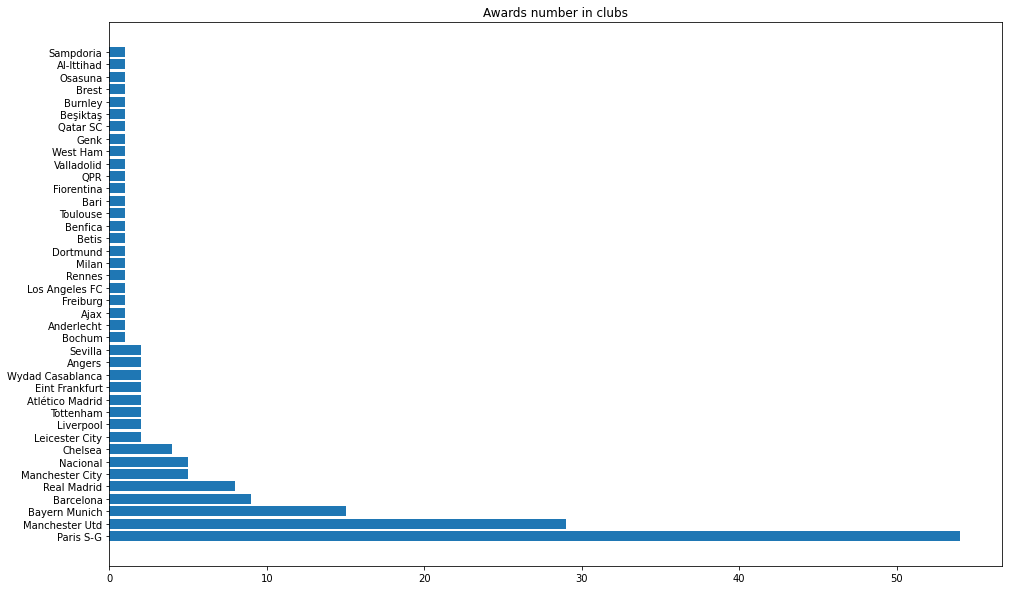

In [23]:
local_query = f"""
PREFIX fifa: <http://www.fifastat.org/>

SELECT ?club (COUNT(?award) as ?awardNum)
WHERE {{
    ?uri rdfs:label ?player ;
         fifa:award ?award ;
         fifa:club ?club
}}
GROUP BY ?club
ORDER BY ?awardNum
"""

local_response = graph.query(local_query)

name = []
counter = []

for row in local_response:
    name.append(str(row.club))
    counter.append(int(row.awardNum))

fig, ax = plt.subplots(figsize =(16, 10))
ax.barh(name, counter)
ax.invert_yaxis()    
ax.set_title('Awards number in clubs')
plt.show()